In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2022-07-29 10:00
# @Author  : zhangbowen

In [2]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import random
from utils.utils import normalization, standardization, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
# standardization (distribution -> mean=0, std=1, [0, 1]/[-1, 1])
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
# Normalization (distribution -> constant, [0, 1])
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc

# 1. Data preparation

#### read row data

In [3]:
data_path = r'data/IMB_HR_employee_attrition.csv' 
df = pd.read_csv(data_path, encoding='utf-8', low_memory=False) 
df.shape

(1470, 35)

#### move labels to last column

In [4]:
pop_df = df.pop('Attrition')
df.insert(df.shape[1], pop_df.name, pop_df)

#### label encoding

In [5]:
# 'No'-> 0 (negative)
df['Attrition'].replace(to_replace='No', value=0, inplace=True)
# 'Yes' -> 1 (positive)
df['Attrition'].replace(to_replace='Yes', value=1, inplace=True)

for i in range(2): 
    print('label {}: {}'.format(i, sum(df['Attrition']==i)))

label 0: 1233
label 1: 237


#### split features to category & numeric

In [6]:
category = [f for f in df.columns if df.dtypes[f] =='object'] 
numeric = [f for f in df.columns if df.dtypes[f] !='object']
print('category:', len(category))
# print(category)
print('numeric', len(numeric))
# print(numeric)

category: 8
numeric 27


#### ねじり　まだ　暫く必要なし

#### features selection

In [7]:
# ######### categorical features ##########
# 'BusinessTravel'：商务差旅频率，Non-Travel不出差，Travel_Rarely不经常出差，Travel_Frequently经常出差, 
# 'Department'：员工所在部门，Sales销售部，Research & Development研发部，Human Resources人力资源部,
# 'EducationField'：员工所学习的专业领域，Life Sciences生命科学，Medical医疗，Marketing市场营销，Technical Degree技术学位，Human Resources人力资源，Other其他, 
# 'Gender'：员工性别，Male男性，Female女性, 
# 'JobRole'：工作角色：Sales Executive销售主管，Research Scientist科学研究员，Laboratory Technician实验室技术员，Manufacturing Director制造总监，Healthcare Representative医疗代表，Manager经理，Sales Representative销售代表，Research Director研究总监，Human Resources人力资源
# 'MaritalStatus'：员工婚姻状况，Single单身，Married已婚，Divorced离婚, 
# (deleted)'Over18'：年龄是否超过18岁, 
# 'OverTime'：是否加班，Yes表示加班，No表示不加班, 


# ######### numeric features ##########
# 'Age'：员工年龄, 
# (not deleted)'DailyRate'：日薪, 
# 'DistanceFromHome'：公司跟家庭住址的距离，从1到29，1最近，29最远, 
# 'Education'：员工的教育程度，从1到5，5教育程度最高, 
# (deleted)'EmployeeCount'：员工人数,
# (deleted)'EmployeeNumber'：员工号码, 
# 'EnvironmentSatisfaction'：员工对于工作环境的满意程度，从1到4，1的满意程度最低，4的满意程度最高, 
# (not deleted)'HourlyRate'：时薪,
# 'JobInvolvement'：员工工作投入度，从1到4，1为投入度最低，4为投入度最高, 
# 'JobLevel'：职业级别，从1到5，1为最低级别，5为最高级别, 
# 'JobSatisfaction'：工作满意度，从1到4，1满意程度最低，4满意程度最高,
# (not deleted)'MonthlyIncome'：员工月收入，范围在1009到19999之间, 
# 'MonthlyRate'：月薪, 
# 'NumCompaniesWorked'：员工曾经工作过的公司数,
# 'PercentSalaryHike'：工资提高的百分比, 
# 'PerformanceRating'：绩效评估, 
# 'RelationshipSatisfaction'：关系满意度，从1到4，1满意度最低，4满意度最高, 
# (deleted)'StandardHours'：标准工时, 
# 'StockOptionLevel'：股票期权水平,
# 'TotalWorkingYears'：总工龄, 
# 'TrainingTimesLastYear'：上一年的培训时长，从0到6，0没有培训，6培训时间最长, 
# 'WorkLifeBalance'：工作与生活平衡程度，从1到4，1平衡程度最低，4平衡程度最高, 
# 'YearsAtCompany'：在目前公司工作年数, 
# 'YearsInCurrentRole'：在目前工作职责的工作年数, 
# 'YearsSinceLastPromotion'：距离上次升职时长,
# 'YearsWithCurrManager'：跟目前的管理者共事年数,
# 'Attrition'：员工是否已经离职，0表示未离职，1表示已经离职,

#### summarize features & label into a dataframe

In [8]:
new_df = pd.DataFrame(df, columns=[
    'BusinessTravel', # categorical features
    'Department',
    'EducationField', 
    'Gender',
    'JobRole',
    'MaritalStatus',
    'OverTime',
    'Age', # numeric features
    'DailyRate', # (not deleted)
    'DistanceFromHome',
    'Education',
    'EnvironmentSatisfaction',
    'HourlyRate', # (not deleted)
    'JobInvolvement',
    'JobLevel',
    'JobSatisfaction',
    'MonthlyIncome', # (not deleted)
    'MonthlyRate',
    'NumCompaniesWorked',
    'PercentSalaryHike',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'TotalWorkingYears',
    'TrainingTimesLastYear',
    'WorkLifeBalance',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager',
    'Attrition' # label
])

new_df.shape

(1470, 31)

# 2. Data analysis

In [9]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   BusinessTravel            1470 non-null   object
 1   Department                1470 non-null   object
 2   EducationField            1470 non-null   object
 3   Gender                    1470 non-null   object
 4   JobRole                   1470 non-null   object
 5   MaritalStatus             1470 non-null   object
 6   OverTime                  1470 non-null   object
 7   Age                       1470 non-null   int64 
 8   DailyRate                 1470 non-null   int64 
 9   DistanceFromHome          1470 non-null   int64 
 10  Education                 1470 non-null   int64 
 11  EnvironmentSatisfaction   1470 non-null   int64 
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

#### category: count(=sum of not missing data), unique(=set), top(=category of highest frequency), freq(=highest frequency)

In [10]:
new_df.describe(include=['O'])

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
count,1470,1470,1470,1470,1470,1470,1470
unique,3,3,6,2,9,3,2
top,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,No
freq,1043,961,606,882,326,673,1054


#### numeri: count, mean, std, min, 25%, 50%, 75%, max

In [11]:
new_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,...,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,0.161224
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,...,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,0.367863
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,...,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,...,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,...,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,0.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,...,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,1.000000


#### split features to category & numeric

In [12]:
category = [f for f in new_df.columns if new_df.dtypes[f] =='object'] 
numeric = [f for f in new_df.columns if new_df.dtypes[f] !='object']
print('category:', len(category))
# print(category)
print('numeric', len(numeric))
# print(numeric)

category: 7
numeric 24


#### relationship of numeric & label

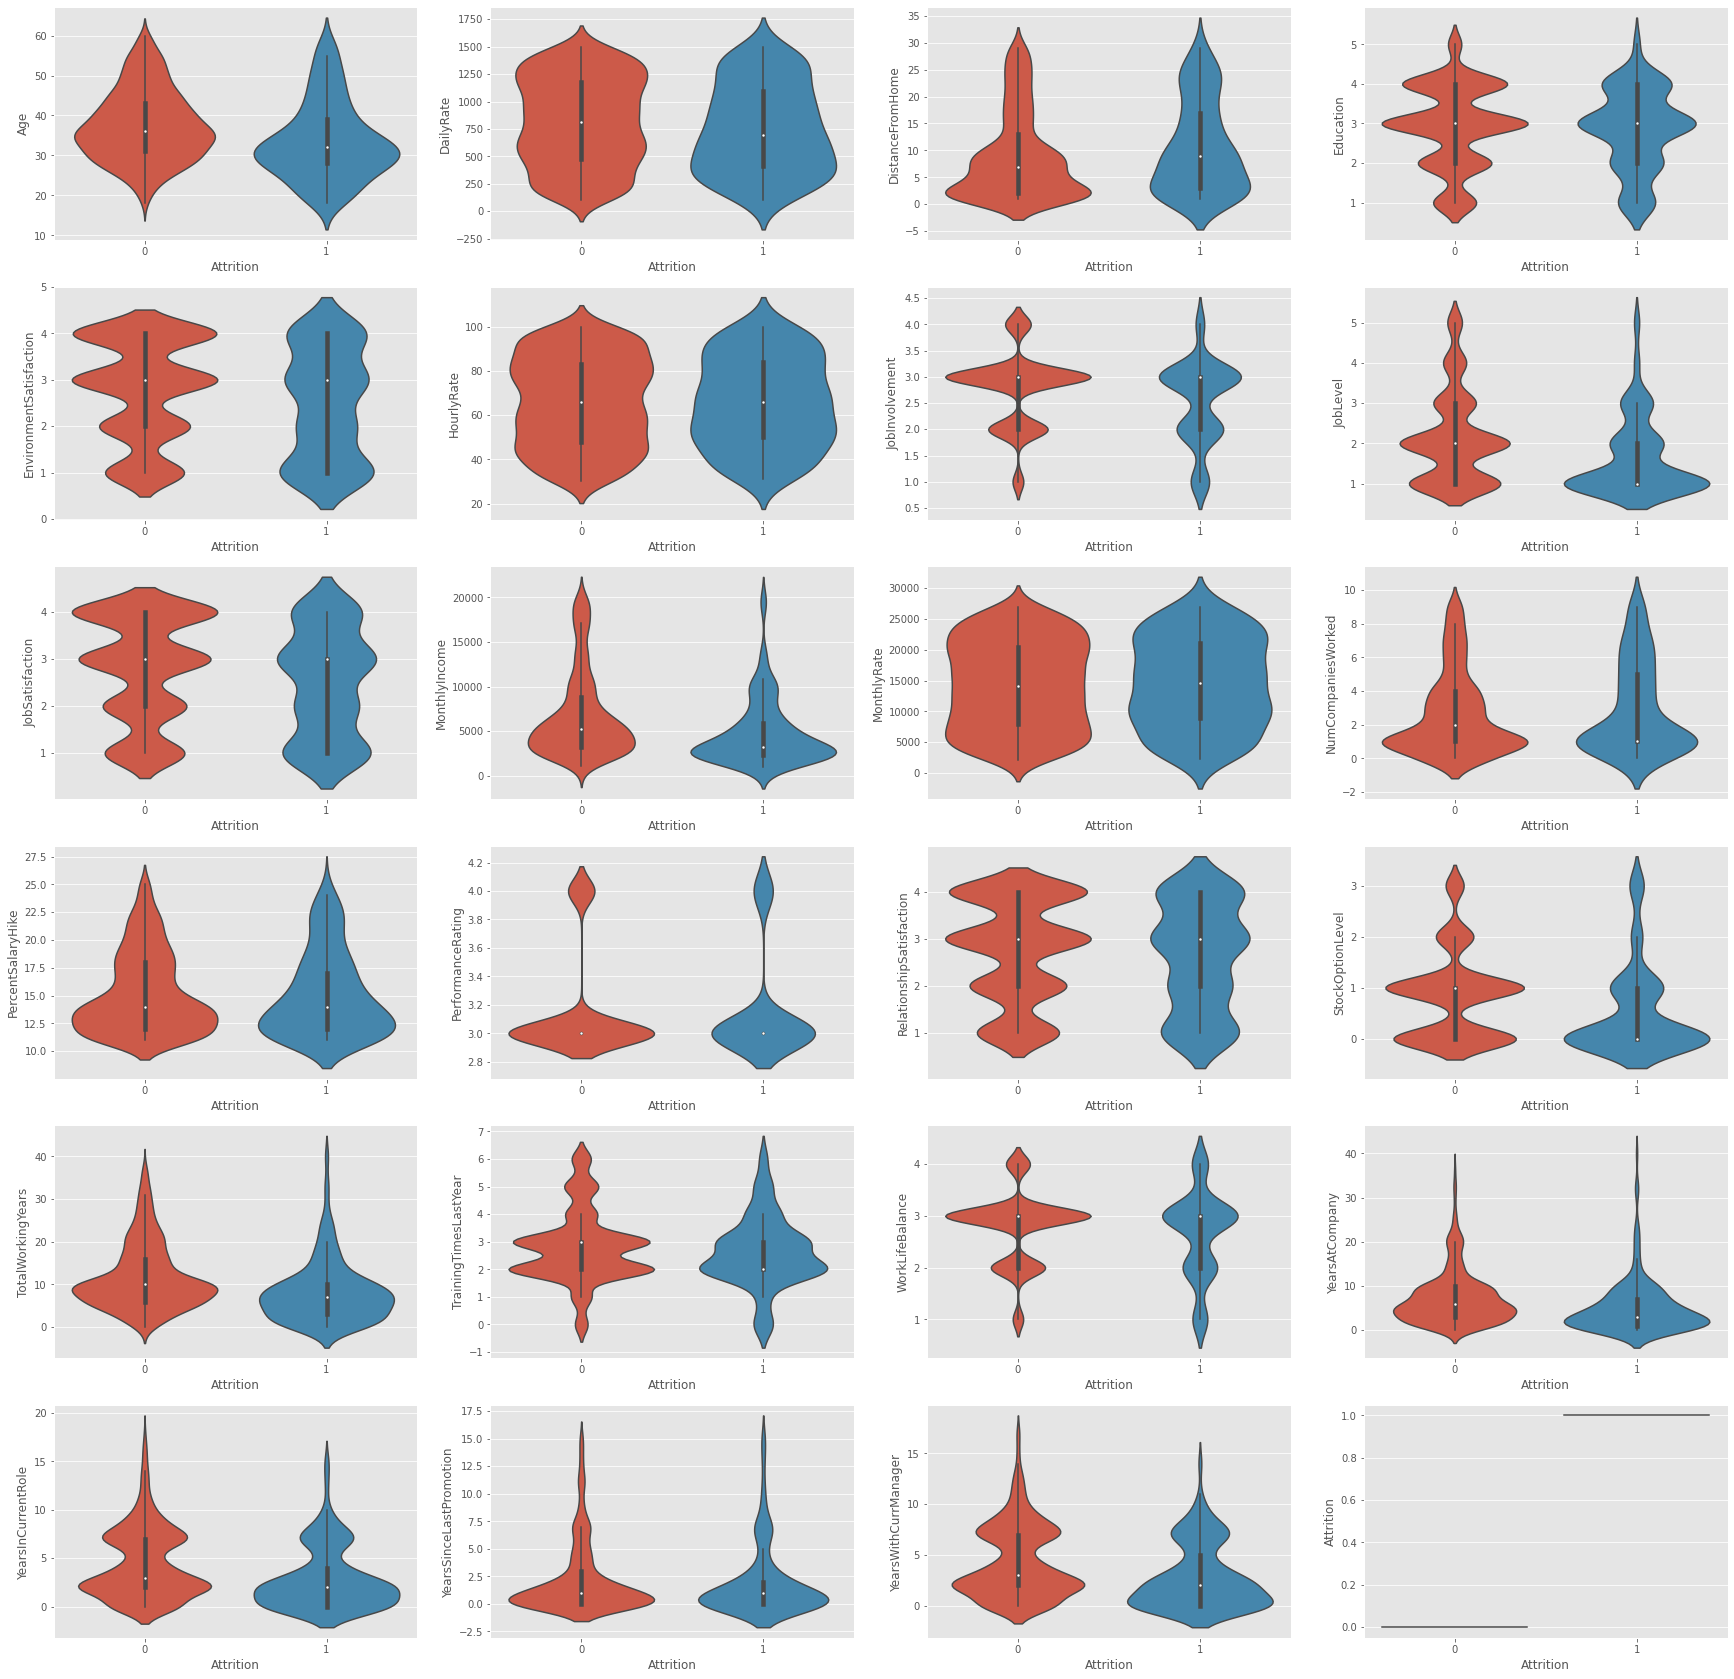

In [13]:
'''
sns.barplot() -> (mean)
sns.boxplot() -> (max, upper quartile, median, lower quartile, min)
sns.violinplot() -> (density distribution)
plt.scatter() -> (all datapoints)
sns.swarmplot -> (all datapoints)
'''
plt.figure(figsize=(30, 30))
for numeric_column in numeric:
    plt.subplot(6, 4, numeric.index(numeric_column)+1)
    sns.violinplot(data=df, x='Attrition', y=numeric_column)
plt.show()

#### distribution of numeric

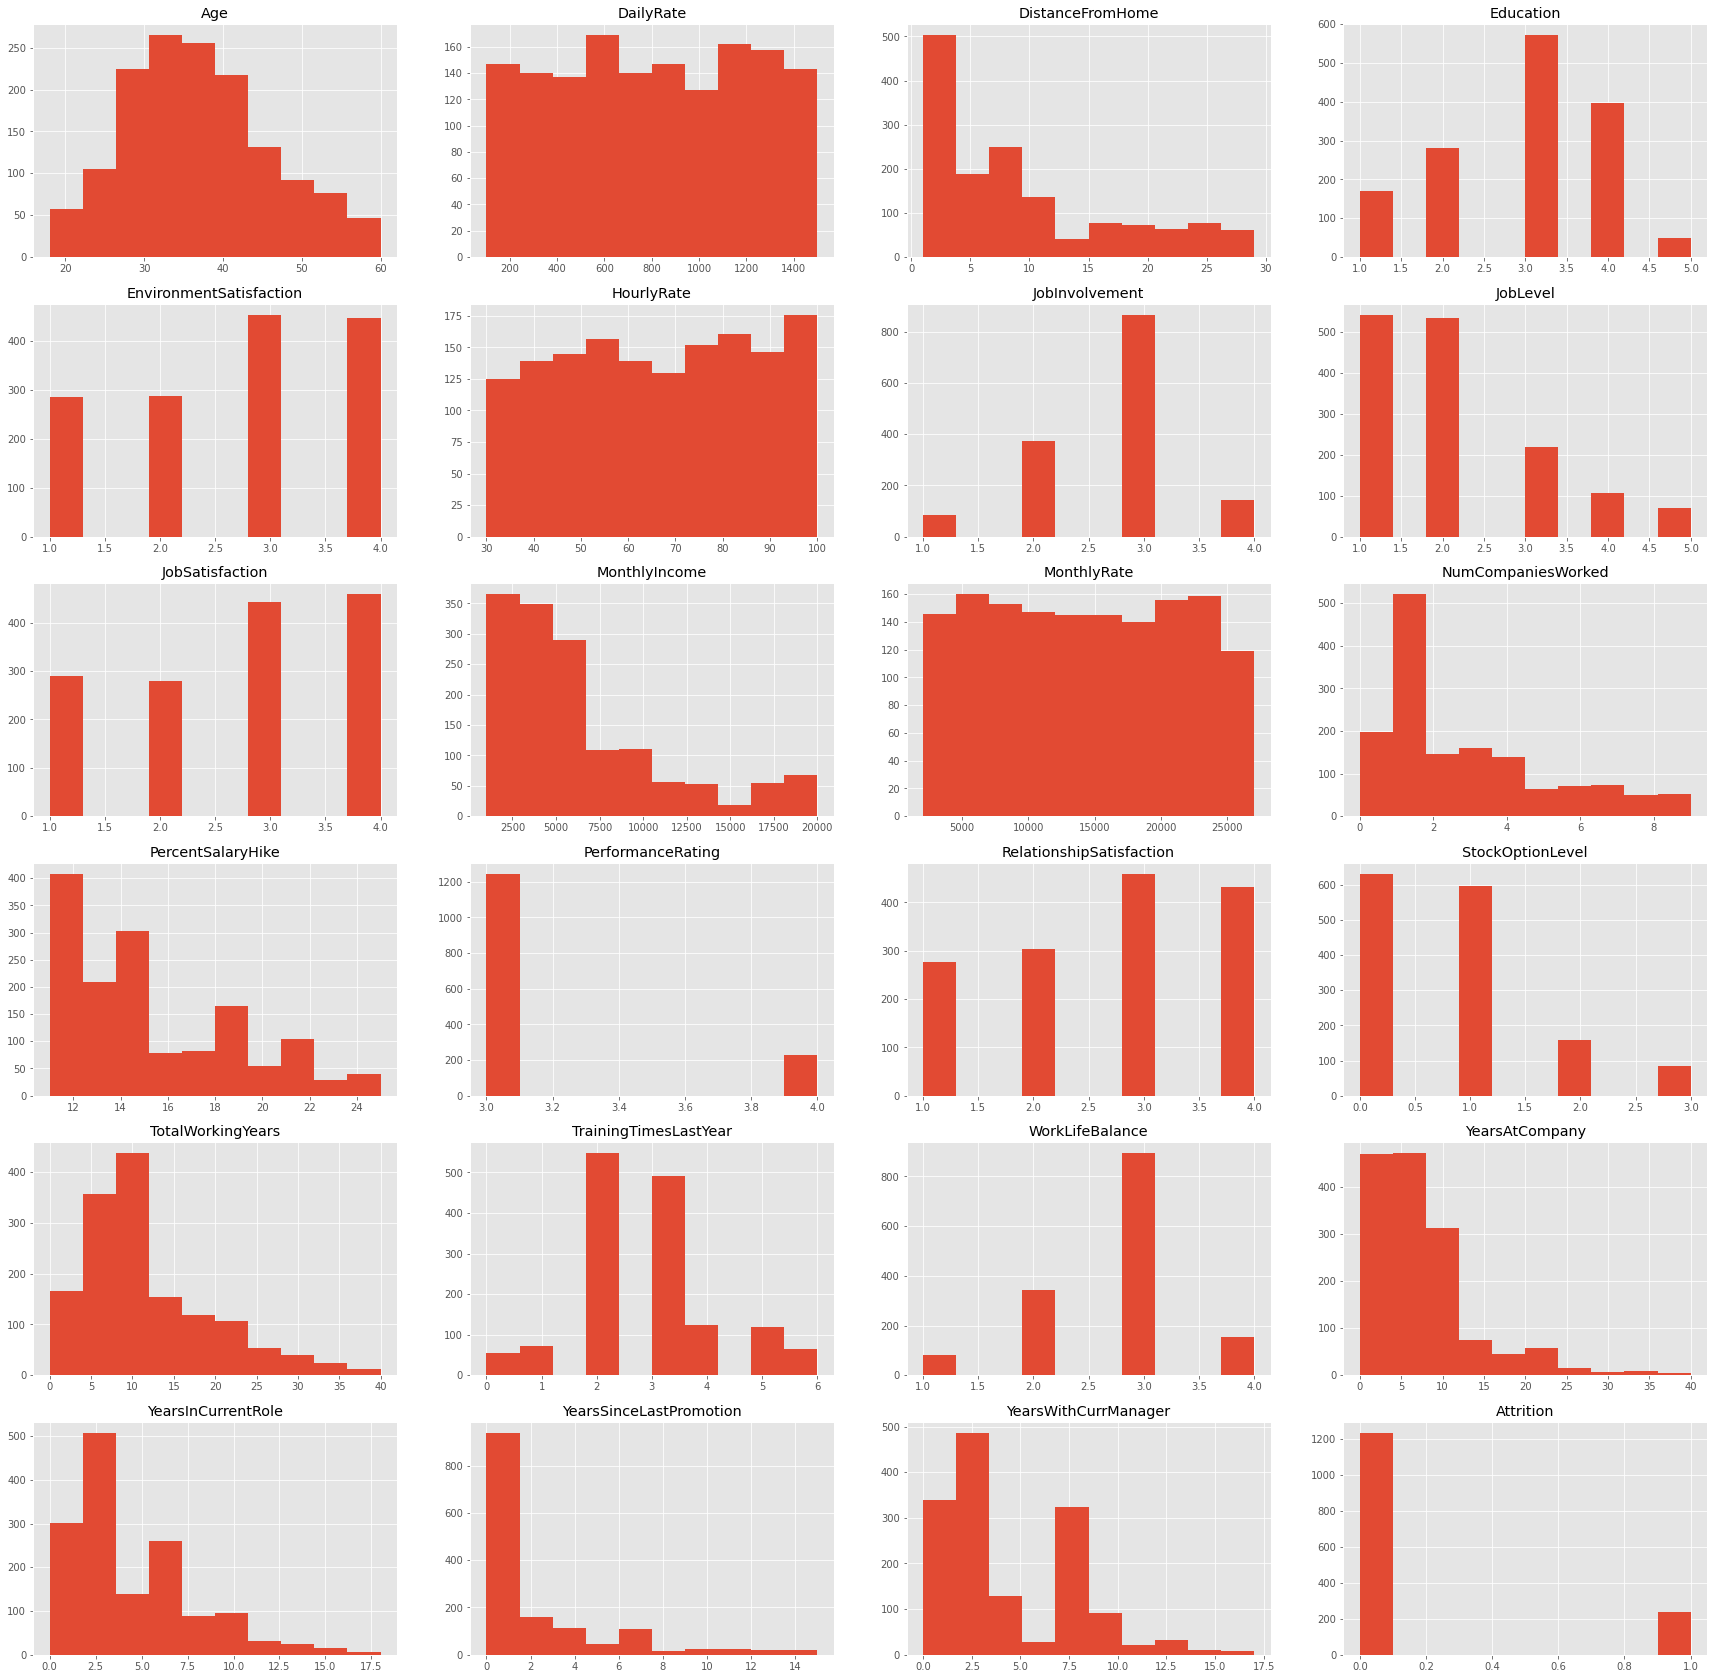

In [14]:
plt.figure(figsize=(30, 30))
for numeric_column in numeric:
    plt.subplot(6, 4, numeric.index(numeric_column)+1)
    plt.title(numeric_column)
    new_df[numeric_column].hist()
plt.show()

#### correlation coeficient of numeric & label

In [15]:
'''
0.8<|CorrCoef|: high correlation
0.5<|CorrCoef|<0.8: middle correlation
0.3<|CorrCoef|<0.5: low correlation
0.3<|CorrCoef|: no correlation
'''
for numeric_column in numeric:
    x = new_df[numeric_column]
    y = new_df['Attrition']
    cov = ((x-x.mean()) * (y-y.mean())).mean()
    corrcoef = cov / (x.std() * y.std())
    print('{}: {:.2f}'.format(numeric_column, corrcoef))

Age: -0.16
DailyRate: -0.06
DistanceFromHome: 0.08
Education: -0.03
EnvironmentSatisfaction: -0.10
HourlyRate: -0.01
JobInvolvement: -0.13
JobLevel: -0.17
JobSatisfaction: -0.10
MonthlyIncome: -0.16
MonthlyRate: 0.02
NumCompaniesWorked: 0.04
PercentSalaryHike: -0.01
PerformanceRating: 0.00
RelationshipSatisfaction: -0.05
StockOptionLevel: -0.14
TotalWorkingYears: -0.17
TrainingTimesLastYear: -0.06
WorkLifeBalance: -0.06
YearsAtCompany: -0.13
YearsInCurrentRole: -0.16
YearsSinceLastPromotion: -0.03
YearsWithCurrManager: -0.16
Attrition: 1.00


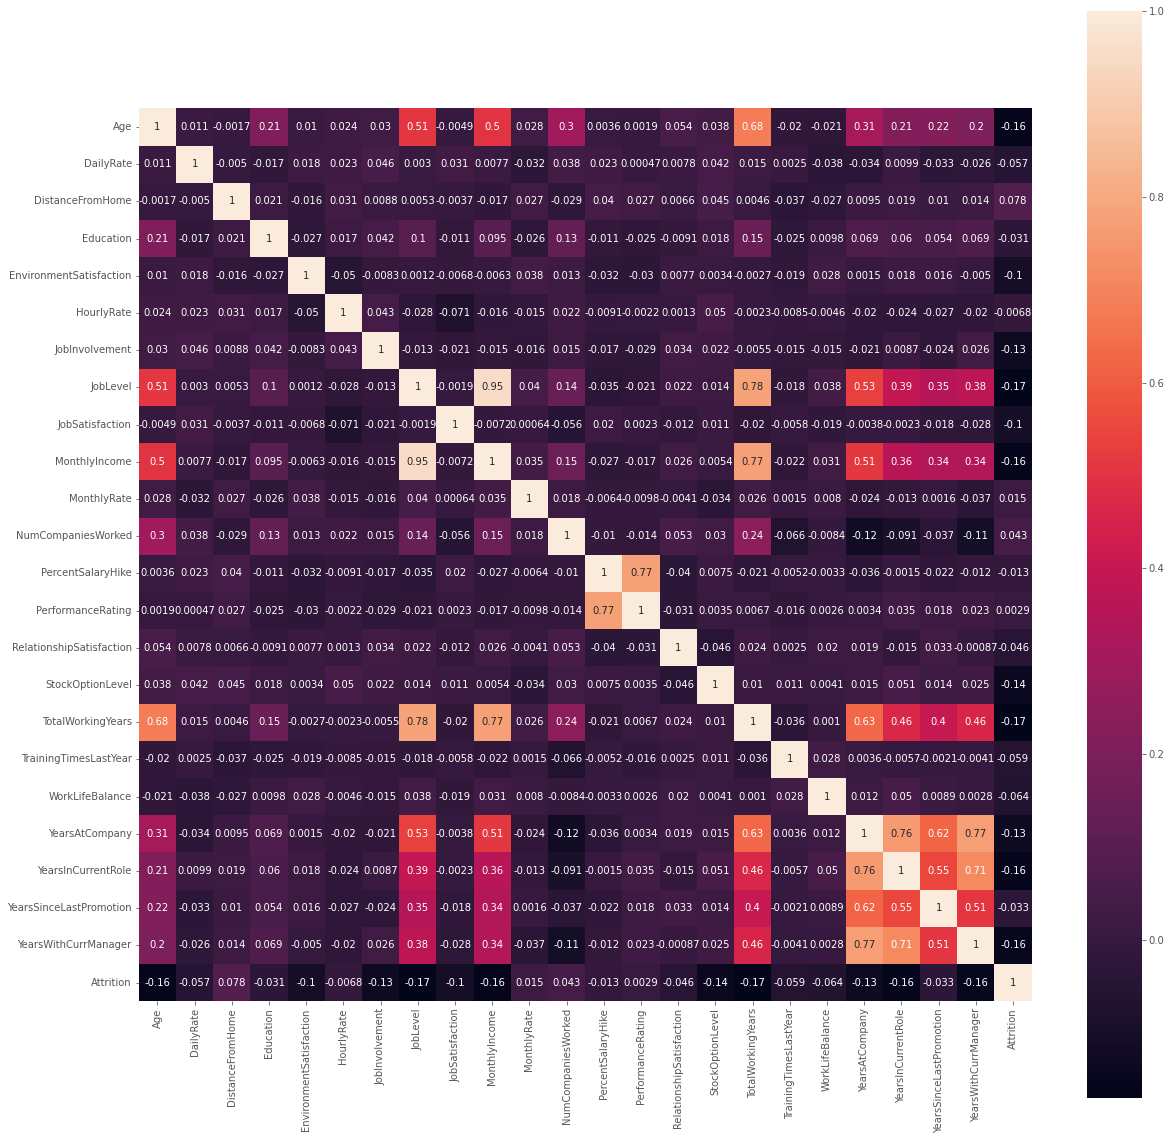

In [16]:
corrcoef_matrix = new_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corrcoef_matrix, annot=True, square=True)
plt.show()

# 3. Data preprocessing

#### distribution of numeric (whether skewness)

In [17]:
# '''
# right/positively skewed distribution(mode < median <mean): use np.log1p()
# left/negatively skewed distribution(mean < median < mode): use np.expm1()
# '''

# for r_skewed_column in ['DistanceFromHome', 'NumCompaniesWorked', 'PercentSalaryHike', 
#                         'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 
#                         'YearsSinceLastPromotion', 'YearsWithCurrManager']:

#     print('-----', r_skewed_column, '-----')
#     new_df[r_skewed_column].hist()
#     plt.show()

#     new_df[r_skewed_column] = np.log1p(new_df[r_skewed_column])
#     new_df[r_skewed_column].hist()
#     plt.show()

#### standardization & normalization of numeric

In [18]:
scaler = MinMaxScaler()

norm_list = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 
             'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 
             'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
             'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 
             'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
]
             
for column in norm_list:
    new_df[column] = scaler.fit_transform(new_df[column].values.reshape(-1, 1))  

In [19]:
new_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.00000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,0.450567,0.501421,0.292590,0.478231,0.573923,0.512731,0.576644,0.265986,0.576190,0.289307,...,0.570748,0.264626,0.28199,0.466553,0.587075,0.175204,0.234958,0.145850,0.242537,0.161224
std,0.217509,0.288840,0.289531,0.256041,0.364361,0.290420,0.237187,0.276735,0.367615,0.247918,...,0.360403,0.284026,0.19452,0.214878,0.235492,0.153163,0.201285,0.214829,0.209890,0.367863
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.285714,0.259843,0.035714,0.250000,0.333333,0.257143,0.333333,0.000000,0.333333,0.100158,...,0.333333,0.000000,0.15000,0.333333,0.333333,0.075000,0.111111,0.000000,0.117647,0.000000
50%,0.428571,0.501074,0.214286,0.500000,0.666667,0.514286,0.666667,0.250000,0.666667,0.205898,...,0.666667,0.333333,0.25000,0.500000,0.666667,0.125000,0.166667,0.066667,0.176471,0.000000
75%,0.595238,0.755190,0.464286,0.750000,1.000000,0.767857,0.666667,0.500000,1.000000,0.388099,...,1.000000,0.333333,0.37500,0.500000,0.666667,0.225000,0.388889,0.200000,0.411765,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### category outliers

In [20]:
# check various types of each category 
category = [f for f in new_df.columns if new_df.dtypes[f] =='object'] 

for column in category:
    print('**********'+column+'**********')
    print(new_df[column].value_counts())
    print('*'*40)

**********BusinessTravel**********
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64
****************************************
**********Department**********
Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64
****************************************
**********EducationField**********
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64
****************************************
**********Gender**********
Male      882
Female    588
Name: Gender, dtype: int64
****************************************
**********JobRole**********
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Represen

In [21]:
# new_df.drop(new_df[new_df['Industry']=='士業'].index, inplace=True)
# new_df.drop(new_df[new_df['Industry']=='教育・研修'].index, inplace=True)
# new_df.drop(new_df[new_df['Industry']=='その他'].index, inplace=True)

# new_df.drop(new_df[new_df['Education']=='その他'].index, inplace=True)

# new_df.drop(new_df[new_df['EmployeeLevel']=='出向／業務委託'].index, inplace=True)
# new_df.drop(new_df[new_df['EmployeeLevel']=='その他'].index, inplace=True)
# new_df.drop(new_df[new_df['EmployeeLevel']=='経営者・役員'].index, inplace=True)
# new_df.drop(new_df[new_df['EmployeeLevel']=='嘱託社員（再雇用）'].index, inplace=True)

# new_df.drop(new_df[new_df['EmployeeField']=='軽作業'].index, inplace=True)
# new_df.drop(new_df[new_df['EmployeeField']=='輸送・機械運転'].index, inplace=True)
# new_df.drop(new_df[new_df['EmployeeField']=='警備・設備管理等'].index, inplace=True)
# new_df.drop(new_df[new_df['EmployeeField']=='建設・土木技術職'].index, inplace=True)
# new_df.drop(new_df[new_df['EmployeeField']=='事務'].index, inplace=True)

# new_df.drop(new_df[new_df['Annualsalary']==6].index, inplace=True)

#### category encoding (one-hot, ordinary, frequency, ..., etc.)

In [22]:
# only category features
new_df_category = new_df[category]
new_df_category

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Yes
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,No
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Yes
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Yes
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,No
...,...,...,...,...,...,...,...
1465,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,No
1466,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,No
1467,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Yes
1468,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,No


#### one-hot encoding

In [23]:
data_dummies = pd.get_dummies(new_df_category)
data_dummies

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1466,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1467,0,0,1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
1468,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,1,0


#### merge one-hot & numeric & move labels to last column

In [24]:
final_df = pd.concat((new_df.drop(list(new_df_category), axis='columns'), data_dummies), axis=1)
pop_df = final_df.pop('Attrition')
final_df.insert(final_df.shape[1], pop_df.name, pop_df)
final_df

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,0.547619,0.715820,0.000000,0.25,0.333333,0.914286,0.666667,0.25,1.000000,0.262454,...,0,0,1,0,0,0,1,0,1,1
1,0.738095,0.126700,0.250000,0.00,0.666667,0.442857,0.333333,0.25,0.333333,0.217009,...,0,1,0,0,0,1,0,1,0,0
2,0.452381,0.909807,0.035714,0.25,1.000000,0.885714,0.333333,0.00,0.666667,0.056925,...,0,0,0,0,0,0,1,0,1,1
3,0.357143,0.923407,0.071429,0.75,1.000000,0.371429,0.666667,0.00,0.666667,0.100053,...,0,1,0,0,0,1,0,0,1,0
4,0.214286,0.350036,0.035714,0.00,0.000000,0.142857,0.666667,0.00,0.333333,0.129489,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.428571,0.559771,0.785714,0.25,0.666667,0.157143,1.000000,0.25,1.000000,0.082254,...,0,0,0,0,0,1,0,1,0,0
1466,0.500000,0.365784,0.178571,0.00,1.000000,0.171429,0.333333,0.50,0.000000,0.472986,...,0,0,0,0,0,1,0,1,0,0
1467,0.214286,0.037938,0.107143,0.50,0.333333,0.814286,1.000000,0.25,0.333333,0.270300,...,0,0,0,0,0,1,0,0,1,0
1468,0.738095,0.659270,0.035714,0.50,1.000000,0.471429,0.333333,0.25,0.333333,0.230700,...,0,0,1,0,0,1,0,1,0,0


#### 

#### OR only use numeric 

In [25]:
# final_df = new_df

# 4. Feature selection

#### check feature importance via Lasso

feature importance via Lasso
                                   Feature Importance
YearsSinceLastPromotion                  1.369283e-01
JobRole_Sales Representative             1.336505e-01
NumCompaniesWorked                       1.213327e-01
MaritalStatus_Single                     9.640123e-02
JobRole_Laboratory Technician            9.055306e-02
DistanceFromHome                         8.650836e-02
BusinessTravel_Travel_Frequently         8.463523e-02
EducationField_Technical Degree          6.553738e-02
EducationField_Human Resources           1.873648e-02
EducationField_Marketing                 1.332986e-02
JobRole_Human Resources                  1.250454e-02
Gender_Male                              1.573445e-17
JobRole_Research Scientist              -0.000000e+00
JobRole_Manager                         -0.000000e+00
JobRole_Sales Executive                  0.000000e+00
MaritalStatus_Married                    0.000000e+00
Department_Sales                         0.000000e+00

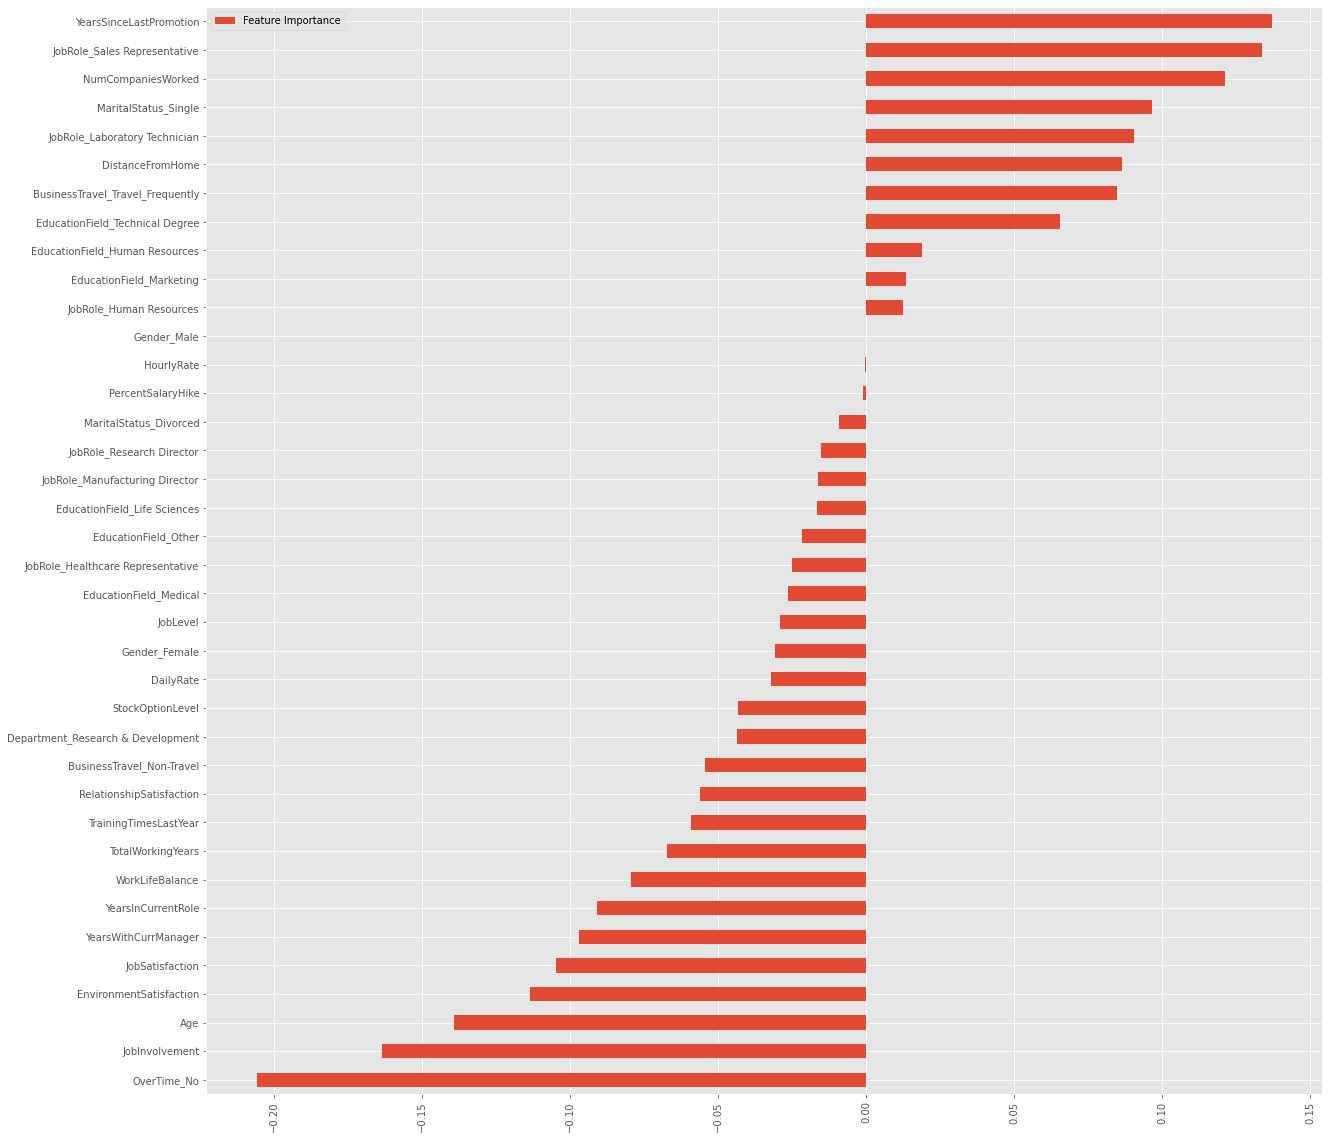

In [26]:
lasso=Lasso(alpha=0.001) # if alpha is so large, coefficients tend to become 0
lasso.fit(final_df.iloc[:, 0:-1], final_df.iloc[:, -1])

FI_lasso = pd.DataFrame({'Feature Importance':lasso.coef_}, index=final_df.columns[0: -1])
print('feature importance via Lasso')
# rank feature importance
print(FI_lasso.sort_values('Feature Importance', ascending=False))
# visualize feature importance
FI_lasso[FI_lasso['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh', figsize=(20, 20))
plt.xticks(rotation=90)
plt.show()

#### select only top n features to use

In [27]:
threshold = 0.01

ranked_features = FI_lasso.sort_values('Feature Importance', ascending=False)['Feature Importance']
selected_features = []
for key, value in ranked_features.items():
    if value >= threshold:
        selected_features.append(key)
    else:
        break
len(selected_features)

11

In [28]:
# selected_features.append('Attrition')
# final_df = final_df[selected_features]
# final_df

# 5. label balance

#### current balance

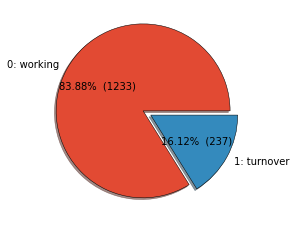

In [29]:
a = final_df.loc[final_df['Attrition']==0].count()[0]
b = final_df.loc[final_df['Attrition']==1].count()[0]
values = [a, b]
labels = ['0: working', '1: turnover']
explode = [0.1, 0]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
plt.show()

#### downsampling (randomly select b (1: positive) from a (0: negative))

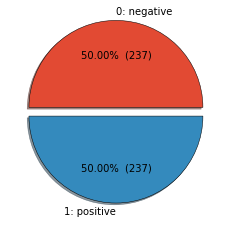

In [30]:
# 0: negative
final_df_0 = final_df[final_df['Attrition']==0].iloc[np.random.randint(0, a, size=b)]
# 1: positive
final_df_1 = final_df[final_df['Attrition']==1]
# merge
final_df = pd.concat([final_df_0, final_df_1])


a = final_df.loc[final_df['Attrition']==0].count()[0]
b = final_df.loc[final_df['Attrition']==1].count()[0]
values = [a, b]
labels = ['0: negative', '1: positive']
explode = [0.1, 0]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
plt.show()

#### dataframe -> csv

In [31]:
# original number of data
final_df.to_csv('data/Attrition/data_utf-8.csv', index=False) # index=False: no write index
# upsampled data
# sample_features.to_csv('data/data_utf-8.csv', index=True)

# 6. Load &  split data for training 

#### read pre-processed data

In [32]:
data_path = r'data/Attrition/data_utf-8.csv' 
df = pd.read_csv(data_path, encoding='utf-8', low_memory=False) # for ignore DtypeWarningb
print(df.shape)
df.describe()

(474, 52)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,...,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,0.415461,0.484856,0.286995,0.459916,0.549930,0.522272,0.556962,0.221519,0.531646,0.246896,...,0.023207,0.206751,0.259494,0.092827,0.213080,0.419831,0.367089,0.616034,0.383966,0.500000
std,0.220124,0.285686,0.292774,0.253885,0.374757,0.288828,0.249339,0.252851,0.379851,0.215675,...,0.150719,0.405403,0.438820,0.290496,0.409916,0.494053,0.482520,0.486864,0.486864,0.500528
min,0.000000,0.000716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.261905,0.239442,0.035714,0.250000,0.333333,0.271429,0.333333,0.000000,0.333333,0.085624,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.380952,0.475304,0.214286,0.500000,0.666667,0.521429,0.666667,0.250000,0.666667,0.188573,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000
75%,0.571429,0.731747,0.464286,0.750000,1.000000,0.771429,0.666667,0.250000,1.000000,0.305055,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,0.976190,0.997853,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998631,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### split dataframe -> features & label -> train & test

In [33]:
features = df.iloc[:, 0:-1]
label = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=1234, stratify=label) # stratify=label: keep label balance in train & test the same as the original data before splitting 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((331, 51), (143, 51), (331,), (143,))

# 7. PCA

In [34]:
# model
pca = PCA(n_components=3, random_state=1234)
# train
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca.shape, X_test_pca.shape

((331, 3), (143, 3))

#### visualize PC distribution

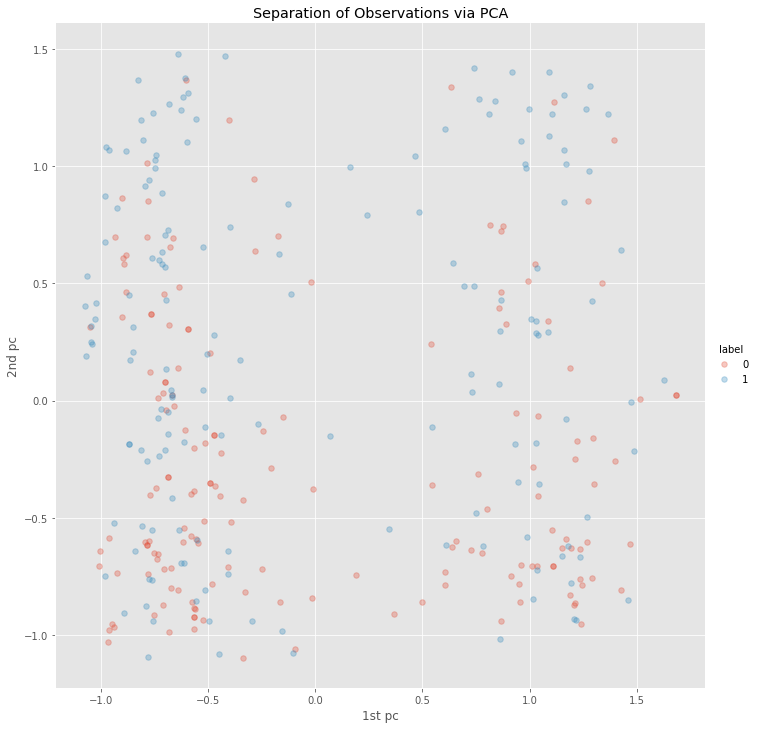

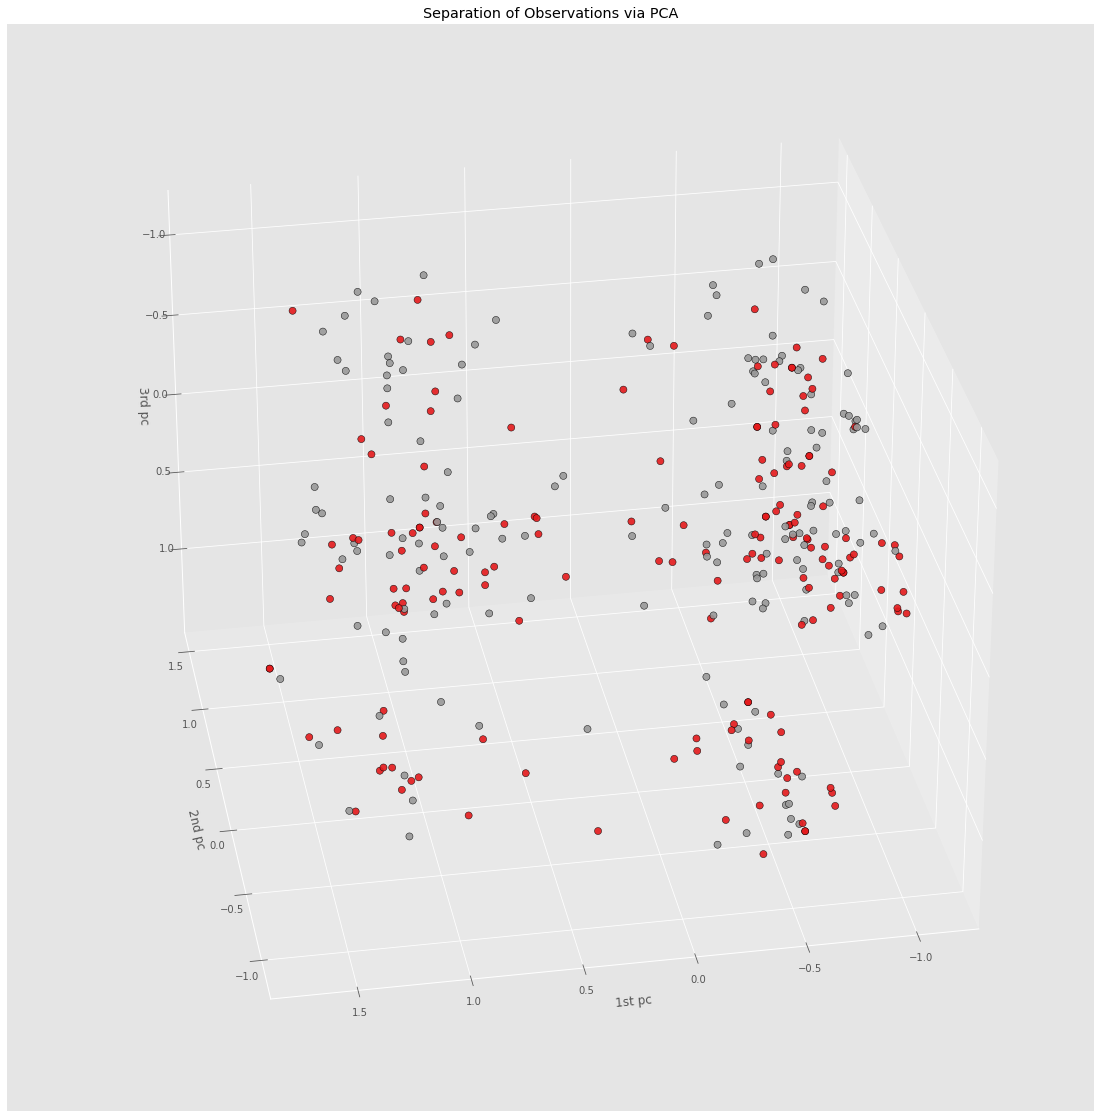

In [35]:
# plot 2D
def plot_2d_pc(xDF, yDF, first_PC, second_PC, algoName):
    tempDF = pd.DataFrame(data=pd.concat((xDF.loc[:, first_PC], xDF.loc[:, second_PC]), axis=1, join='inner'), index=xDF.index)

    tempDF = pd.concat((tempDF, yDF), axis=1, join='inner')
    tempDF.columns = ['1st pc', '2nd pc', 'label']

    sns.lmplot(x='1st pc', y='2nd pc', hue='label',
            data=tempDF, fit_reg=False, height=10,
            scatter_kws={'alpha':0.3, 's':30}
    )
    ax = plt.gca()
    ax.set_title('Separation of Observations via ' + algoName)
    plt.show()


# plot 3D
def plot_3d_pc(xDF, yDF, first_PC, second_PC, third_PC, algoName):
    fig = plt.figure(1, figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d', elev=-150, azim=100)
    ax.set_xlabel('1st pc')
    ax.set_ylabel('2nd pc')
    ax.set_zlabel('3rd pc')
    ax.scatter(
        X_train_pca[:, first_PC],
        X_train_pca[:, second_PC],
        X_train_pca[:, third_PC],
        c=y_train, cmap=plt.cm.Set1, 
        edgecolor='k', s=50, alpha=0.9
    )

    ax.set_title('Separation of Observations via ' + algoName)
    plt.show()


# ndarray -> dataframe for visualization
df_X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

# plot 2D 
plot_2d_pc(df_X_train_pca, y_train, 0, 1, 'PCA')

# plot 3D 
plot_3d_pc(df_X_train_pca, y_train, 0, 1, 2, 'PCA')

#### dataframe --> ndarray

In [36]:
X_train, y_train, X_test, y_test = X_train.values, y_train.values, X_test.values, y_test.values

# original (not pca)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# pca
print(X_train_pca.shape, y_train.shape, X_test_pca.shape, y_test.shape)

(331, 51) (331,) (143, 51) (143,)
(331, 3) (331,) (143, 3) (143,)


# 8. Modeling & Evaluation (train)

#### classifiers

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


models = [LogisticRegression(), DecisionTreeClassifier(), XGBClassifier(),
          KNeighborsClassifier(), GaussianNB(), RandomForestClassifier()
]

names = ['LogisticRegression', 'DecisionTreeClassifier', 'XGBClassifier', 
         'KNeighborsClassifier', 'GaussianNB', 'RandomForestClassifier'
]

#### various score functions & K-folds Cross Validation
[avaliable metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [38]:
num_folds = 5

def acc_cv(model, X, y):
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=num_folds)

    return acc

def balanced_acc_cv(model, X, y):
    balanced_acc = cross_val_score(model, X, y, scoring=make_scorer(balanced_accuracy_score), cv=num_folds)

    return balanced_acc

def precision_cv(model, X, y):
    precision = cross_val_score(model, X, y, scoring='precision', cv=num_folds)

    return precision


def recall_cv(model, X, y):
    recall = cross_val_score(model, X, y, scoring='recall', cv=num_folds)

    return recall


def f1_score_cv(model, X, y):
    f1_score = cross_val_score(model, X, y, scoring='f1', cv=num_folds)

    return f1_score


def auc_cv(model, X, y):
    auc = cross_val_score(model, X, y, scoring=make_scorer(roc_auc_score), cv=num_folds)

    return auc

In [39]:
for name, model in zip(names, models):
    print('----------', name, '----------')
    
    # acc
    score = acc_cv(model, X_train, y_train)
    print('||{}||    ||acc||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # balanced acc
    score = balanced_acc_cv(model, X_train, y_train)
    print('||{}||    ||balanced_acc_cv||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # precision
    score = precision_cv(model, X_train, y_train)
    print('||{}||    ||precision_weighted||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # recall
    score = recall_cv(model, X_train, y_train)
    print('||{}||    ||recall_weighted||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # f1-score
    score = f1_score_cv(model, X_train, y_train)
    print('||{}||    ||f1-score_weighted||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # auc
    score = auc_cv(model, X_train, y_train)
    print('||{}||    ||auc||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

---------- LogisticRegression ----------
||LogisticRegression||    ||acc||    mean sore: 0.7251    std score: 0.0203
||LogisticRegression||    ||balanced_acc_cv||    mean sore: 0.7250    std score: 0.0203
||LogisticRegression||    ||precision_weighted||    mean sore: 0.7128    std score: 0.0157
||LogisticRegression||    ||recall_weighted||    mean sore: 0.7515    std score: 0.0485
||LogisticRegression||    ||f1-score_weighted||    mean sore: 0.7309    std score: 0.0247
||LogisticRegression||    ||auc||    mean sore: 0.7250    std score: 0.0203
---------- DecisionTreeClassifier ----------
||DecisionTreeClassifier||    ||acc||    mean sore: 0.6464    std score: 0.0508
||DecisionTreeClassifier||    ||balanced_acc_cv||    mean sore: 0.6102    std score: 0.0737
||DecisionTreeClassifier||    ||precision_weighted||    mean sore: 0.6449    std score: 0.0664
||DecisionTreeClassifier||    ||recall_weighted||    mean sore: 0.6182    std score: 0.0411
||DecisionTreeClassifier||    ||f1-score_weigh

# 9. Hyperparameters Tuning & Evaluation (train & test)

#### Grid Search & Cross Validation

In [96]:
num_folds = 5
metrics = 'f1'

class GridSearch():
    def __init__(self, model):
        self.model = model
    
    
    def grid_get(self, X, y, param_grid):
        grid_search_CV = GridSearchCV(self.model, param_grid, cv=num_folds, scoring=metrics)
        grid_search_CV.fit(X, y)
        
        best_params = grid_search_CV.best_params_
        best_score = grid_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
        # grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        # print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

        
        return best_params


In [97]:
# GridSearch(LogisticRegression()).grid_get(X_train, y_train, {'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})        
# GridSearch(SVC()).grid_get(X_train, y_train, {'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})
# GridSearch(LinearSVC()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})
# GridSearch(KNeighborsClassifier()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})
# GridSearch(GaussianNB()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})
# GridSearch(RandomForestClassifier()).grid_get(X_train, y_train, param_grid)
# GridSearch(ExtraTreesClassifier()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

# DecisionTreeClassifier
param_grid = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}

model = DecisionTreeClassifier()
GridSearch(model).grid_get(X_train, y_train, param_grid)        

In [ ]:
# XGBClassifier
param_grid = {'eta':[0.01, 0.1, 1.0],
              'gamma':[0, 0.1], 
              'n_estimators':[10, 100],
              'max_depth':[2, 4], 
              'min_child_weigh':[1, 2],
              'nthread':[2]
}

model = XGBClassifier(verbosity=0)
GridSearch(model).grid_get(X_train, y_train, param_grid)

{'eta': 1.0, 'gamma': 0.1, 'max_depth': 2, 'min_child_weigh': 1, 'n_estimators': 100, 'nthread': 2} 0.6000232213132453


#### Randomized Search  & Cross Validation

In [116]:
num_folds = 3
metrics = 'f1'

class RandomizedSearch():
    def __init__(self, model):
        self.model = model
    
    
    def grid_get(self, X, y, random_grid):
        randomized_search_CV = RandomizedSearchCV(
            estimator = model, 
            param_distributions = random_grid, 
            n_iter=100, 
            cv = num_folds, 
            scoring = metrics,
            verbose=2, 
            random_state=4321, 
            n_jobs=-1
        )       
        randomized_search_CV.fit(X, y)

        best_params = randomized_search_CV.best_params_
        best_score = randomized_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
    
        return best_params

In [161]:
# RandomForestClassifier
random_grid = {'n_estimators': [100,200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4], 
               'bootstrap': [True, False]
}

model = RandomForestClassifier(random_state=4321)
best_params = RandomizedSearch(model).grid_get(X_train, y_train, random_grid)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
best params: {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
best score: 0.7199487827806412


========== train ==========
              precision    recall  f1-score   support

  0: working       1.00      1.00      1.00       166
 1: turnover       1.00      1.00      1.00       165

    accuracy                           1.00       331
   macro avg       1.00      1.00      1.00       331
weighted avg       1.00      1.00      1.00       331



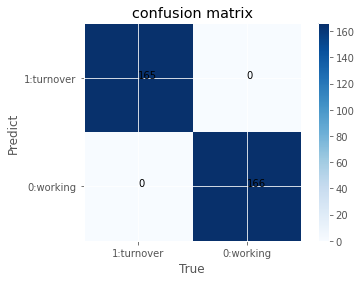

========== test ==========
              precision    recall  f1-score   support

  0: working       0.73      0.86      0.79        71
 1: turnover       0.83      0.68      0.75        72

    accuracy                           0.77       143
   macro avg       0.78      0.77      0.77       143
weighted avg       0.78      0.77      0.77       143



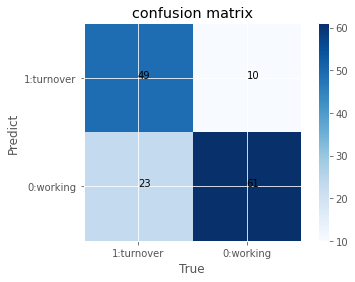

In [171]:
# train
model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)

# inference
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

labels = ['0: working', '1: turnover']

# training score
print('========== train ==========')
print(classification_report(y_train, pred_train, target_names=labels))
confusion_matrix(y_train, pred_train)

# test score
print('========== test ==========')
print(classification_report(y_test, pred_test, target_names=labels))
confusion_matrix(y_test, pred_test)

# 10. model combination

# 11. submission

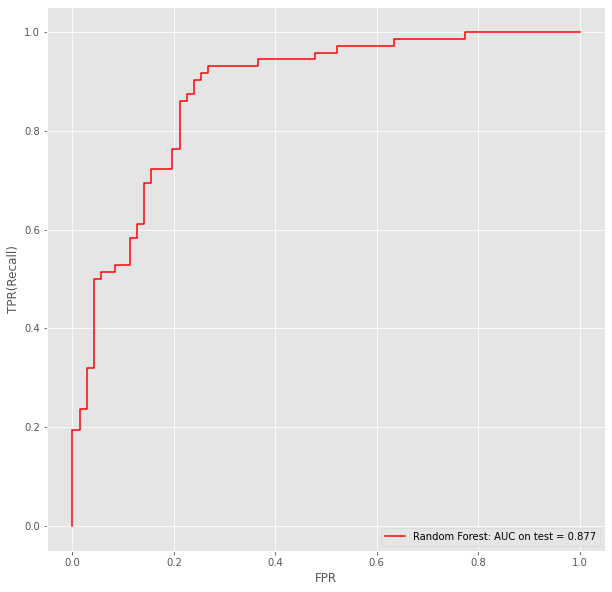

In [189]:
# calculate fpr & tpr
pred_prob = model.predict_proba(X_test)[:, 1] # [:, 1]: prob of label 1
FPR, TPR, thresholds = roc_curve(y_test, pred_prob)
# calculate AUC
AUC = auc(FPR, TPR)

plt.figure(figsize=(10,10))
plt.plot(FPR, TPR, 'r', label='Random Forest: AUC on test = %0.3f' % AUC)
# plt.plot(fpr_tree_clf, tpr_tree_clf, 'y', label = '决策树默认Val AUC = %0.3f' % roc_auc_tree_clf)
plt.xlabel('FPR')
plt.ylabel('TPR(Recall)')
plt.legend(loc=4)
plt.show()